# Comparison of CP-DINO 300 model with CellStats and ImageNet Pretrained Models

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Precomputed Embeddings and Linear Probing Results

In [73]:
import pandas as pd
import numpy as np
import pickle
from cp_posh.analysis import plotting, metrics, aggregate, stringdb, similarity

In [35]:
linear_probing_auc_metrics = np.load("./datasets/linear_probing_metrics/analysis_cpdino_300.pkl", allow_pickle=True)
auc_metrics = None
effect_genes = {}
for embedding_name, aucs in linear_probing_auc_metrics.items():
    if auc_metrics is None:
        x = pd.DataFrame(pd.DataFrame(aucs).T.median(axis=1))
        x.columns = [f'{embedding_name}']
        auc_metrics = x
    else:
        x = pd.DataFrame(pd.DataFrame(aucs).T.median(axis=1))
        x.columns = [f'{embedding_name}']
        auc_metrics = auc_metrics.join(x, rsuffix='')
    x = pd.DataFrame(aucs).median(axis=0)
    effect_genes[embedding_name] = len(x[x>0.6])

/home/ubuntu/software/cp-posh/cp_posh/analysis/plotting.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title, fontsize=12)


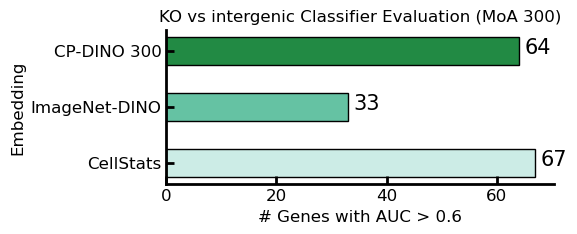

In [43]:
plotting.barplot(
    np.array(list(effect_genes.keys())), 
    np.array(list(effect_genes.values())), 
    "KO vs intergenic Classifier Evaluation (MoA 300)", 
    "# Genes with AUC > 0.6", 
    "Embedding", 
    1, 
    'int'
)

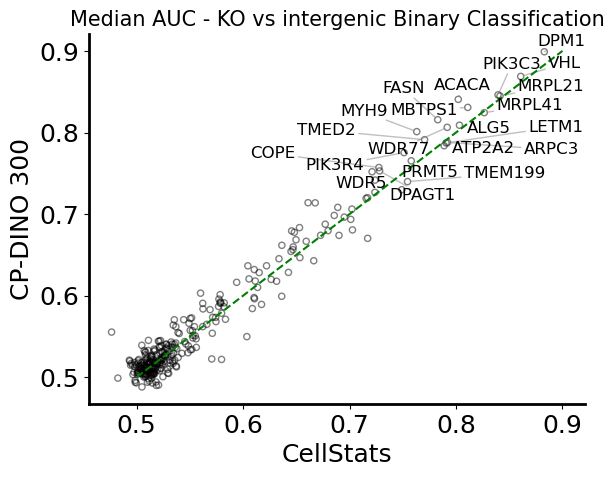

In [41]:
plotting.scatter_plot(
    "CellStats",
    "CP-DINO 300",
    auc_metrics,
    xlabel="CellStats",
    ylabel="CP-DINO 300",
    title="Median AUC - KO vs intergenic Binary Classification"
)

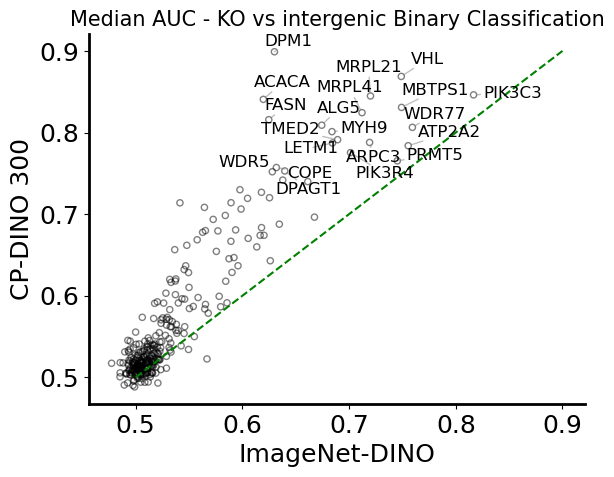

In [44]:
plotting.scatter_plot(
    "ImageNet-DINO",
    "CP-DINO 300",
    auc_metrics,
    xlabel="ImageNet-DINO",
    ylabel="CP-DINO 300",
    title="Median AUC - KO vs intergenic Binary Classification"
)

In [56]:
sgRNA_aggregate_embeddings = {
    "CellStats": pd.read_parquet("./datasets/aggregate_sgRNA_embeddings/cellstats_features_moa_300.pq"),
    "ImageNet-DINO": pd.read_parquet("./datasets/aggregate_sgRNA_embeddings/imagenet_pretrained_embeddings_moa_300.pq"),
    "CP-DINO 300": pd.read_parquet("./datasets/aggregate_sgRNA_embeddings/cpdino_300_embeddings_moa_300.pq"),
}

In [70]:
metrics_all = {}
cpdino_300_gene_embeddings = aggregate.aggregate_embeddings_by_gene(sgRNA_aggregate_embeddings["CP-DINO 300"], method="median")
select_genes = cpdino_300_gene_embeddings.index.values
stringdb_matrix = stringdb.get_stringdb_data(select_genes)
for embedding_name, sgRNA_embeddings in sgRNA_aggregate_embeddings.items():
    gene_embeddings = aggregate.aggregate_embeddings_by_gene(sgRNA_embeddings, method="median")
    results = metrics.compute_stringdb_roc_prc_metrics(
        aggregate_features=gene_embeddings,
        select_genes = select_genes,
        stringdb_threshold=0.95,
        abs_value=True,
        stringdb_matrix=stringdb_matrix,
    )
    metrics_all[embedding_name] = results['roc_tpr_at_5pc_fpr']

/home/ubuntu/software/cp-posh/cp_posh/analysis/plotting.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(x_values, ha="right", rotation_mode="anchor")


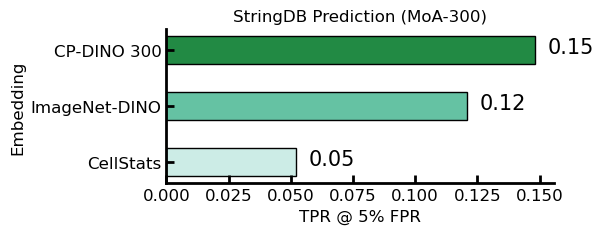

In [71]:
plotting.barplot(list(metrics_all.keys()), list(metrics_all.values()), "StringDB Prediction (MoA-300)", "TPR @ 5% FPR", "Embedding", 0.005, tp="float",)

## Measuring the similarities of gRNAs targeting the same genes

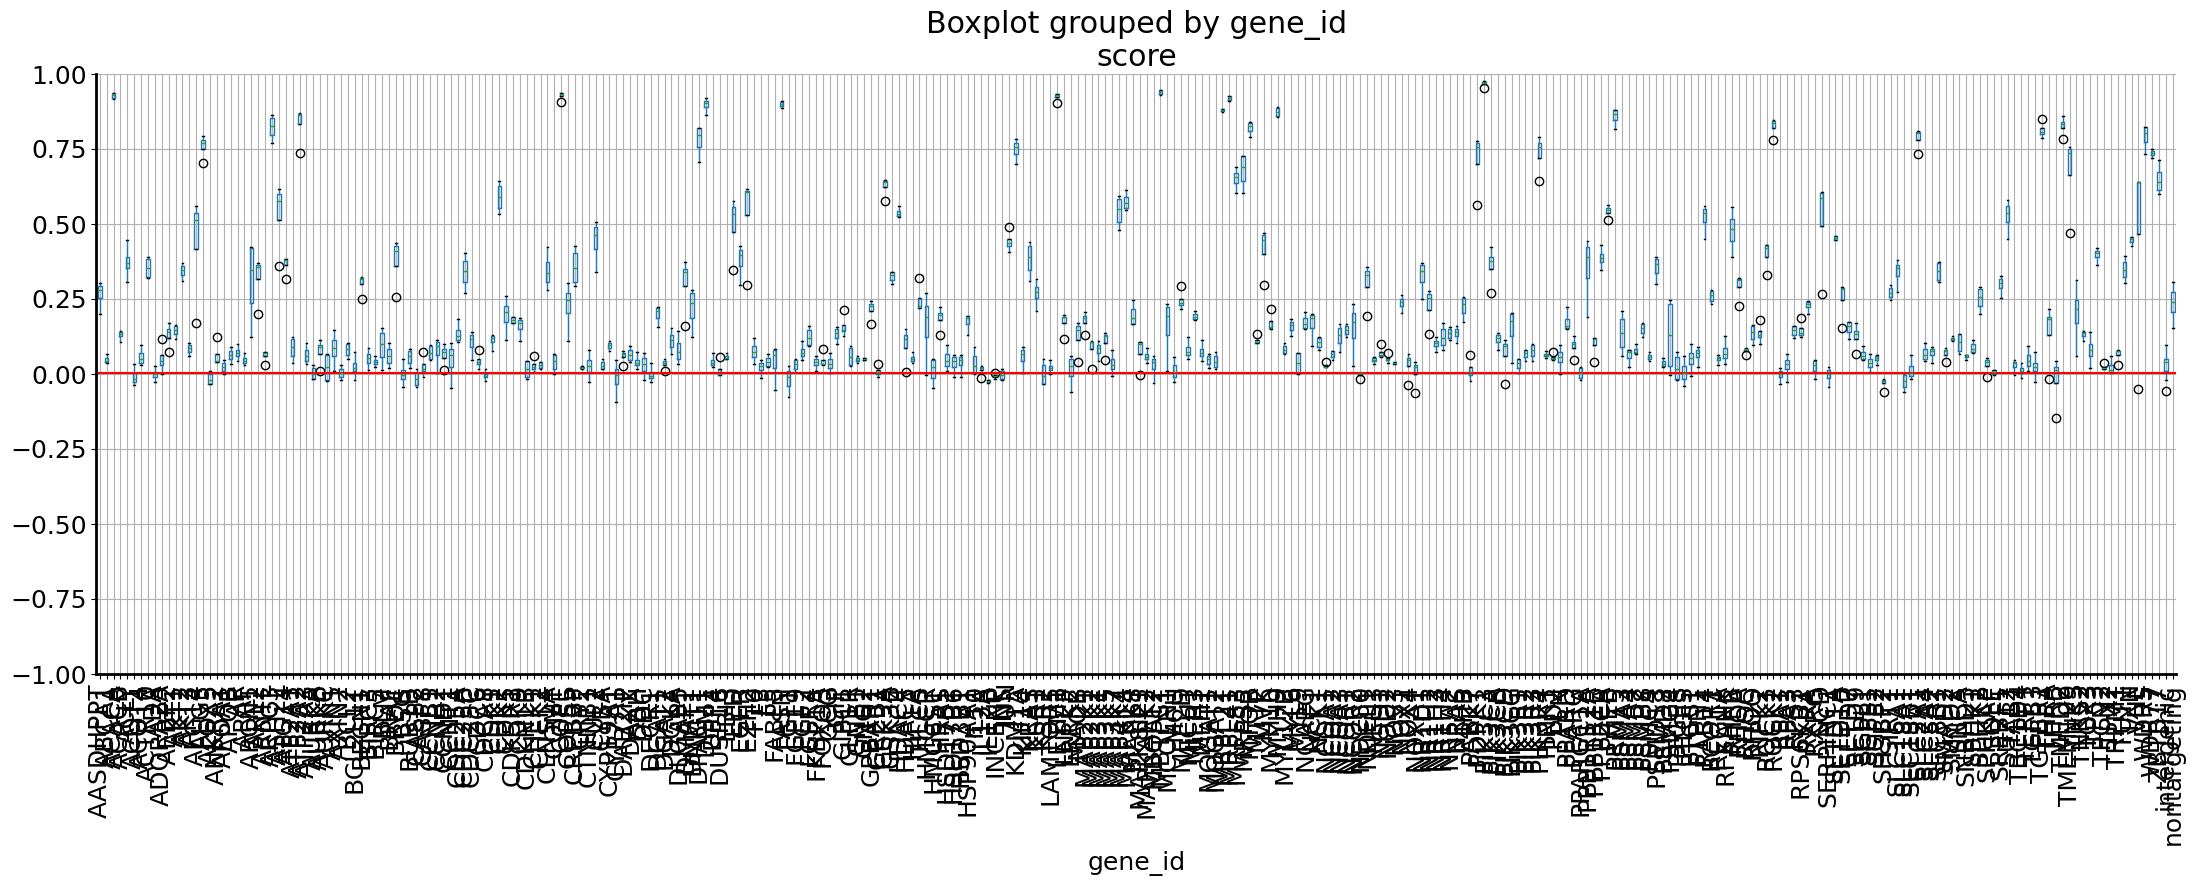

In [83]:
gRNAscores = similarity.get_gRNA_scores(sgRNA_aggregate_embeddings['CP-DINO 300'])
gRNAscores['score'] = gRNAscores['score'].apply(pd.to_numeric)
gRNAscores_simple = pd.DataFrame(index = gRNAscores.index.get_level_values('gene_id'), data={'score':gRNAscores.score.values})
gRNAscores_simple = gRNAscores_simple.groupby('gene_id').mean()

### Visualize Aggregate Gene Embeddings on a UMAP

/home/ubuntu/miniconda3/envs/insitro/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


adjust_text = TRUE, may slow down UMAP plotting time...


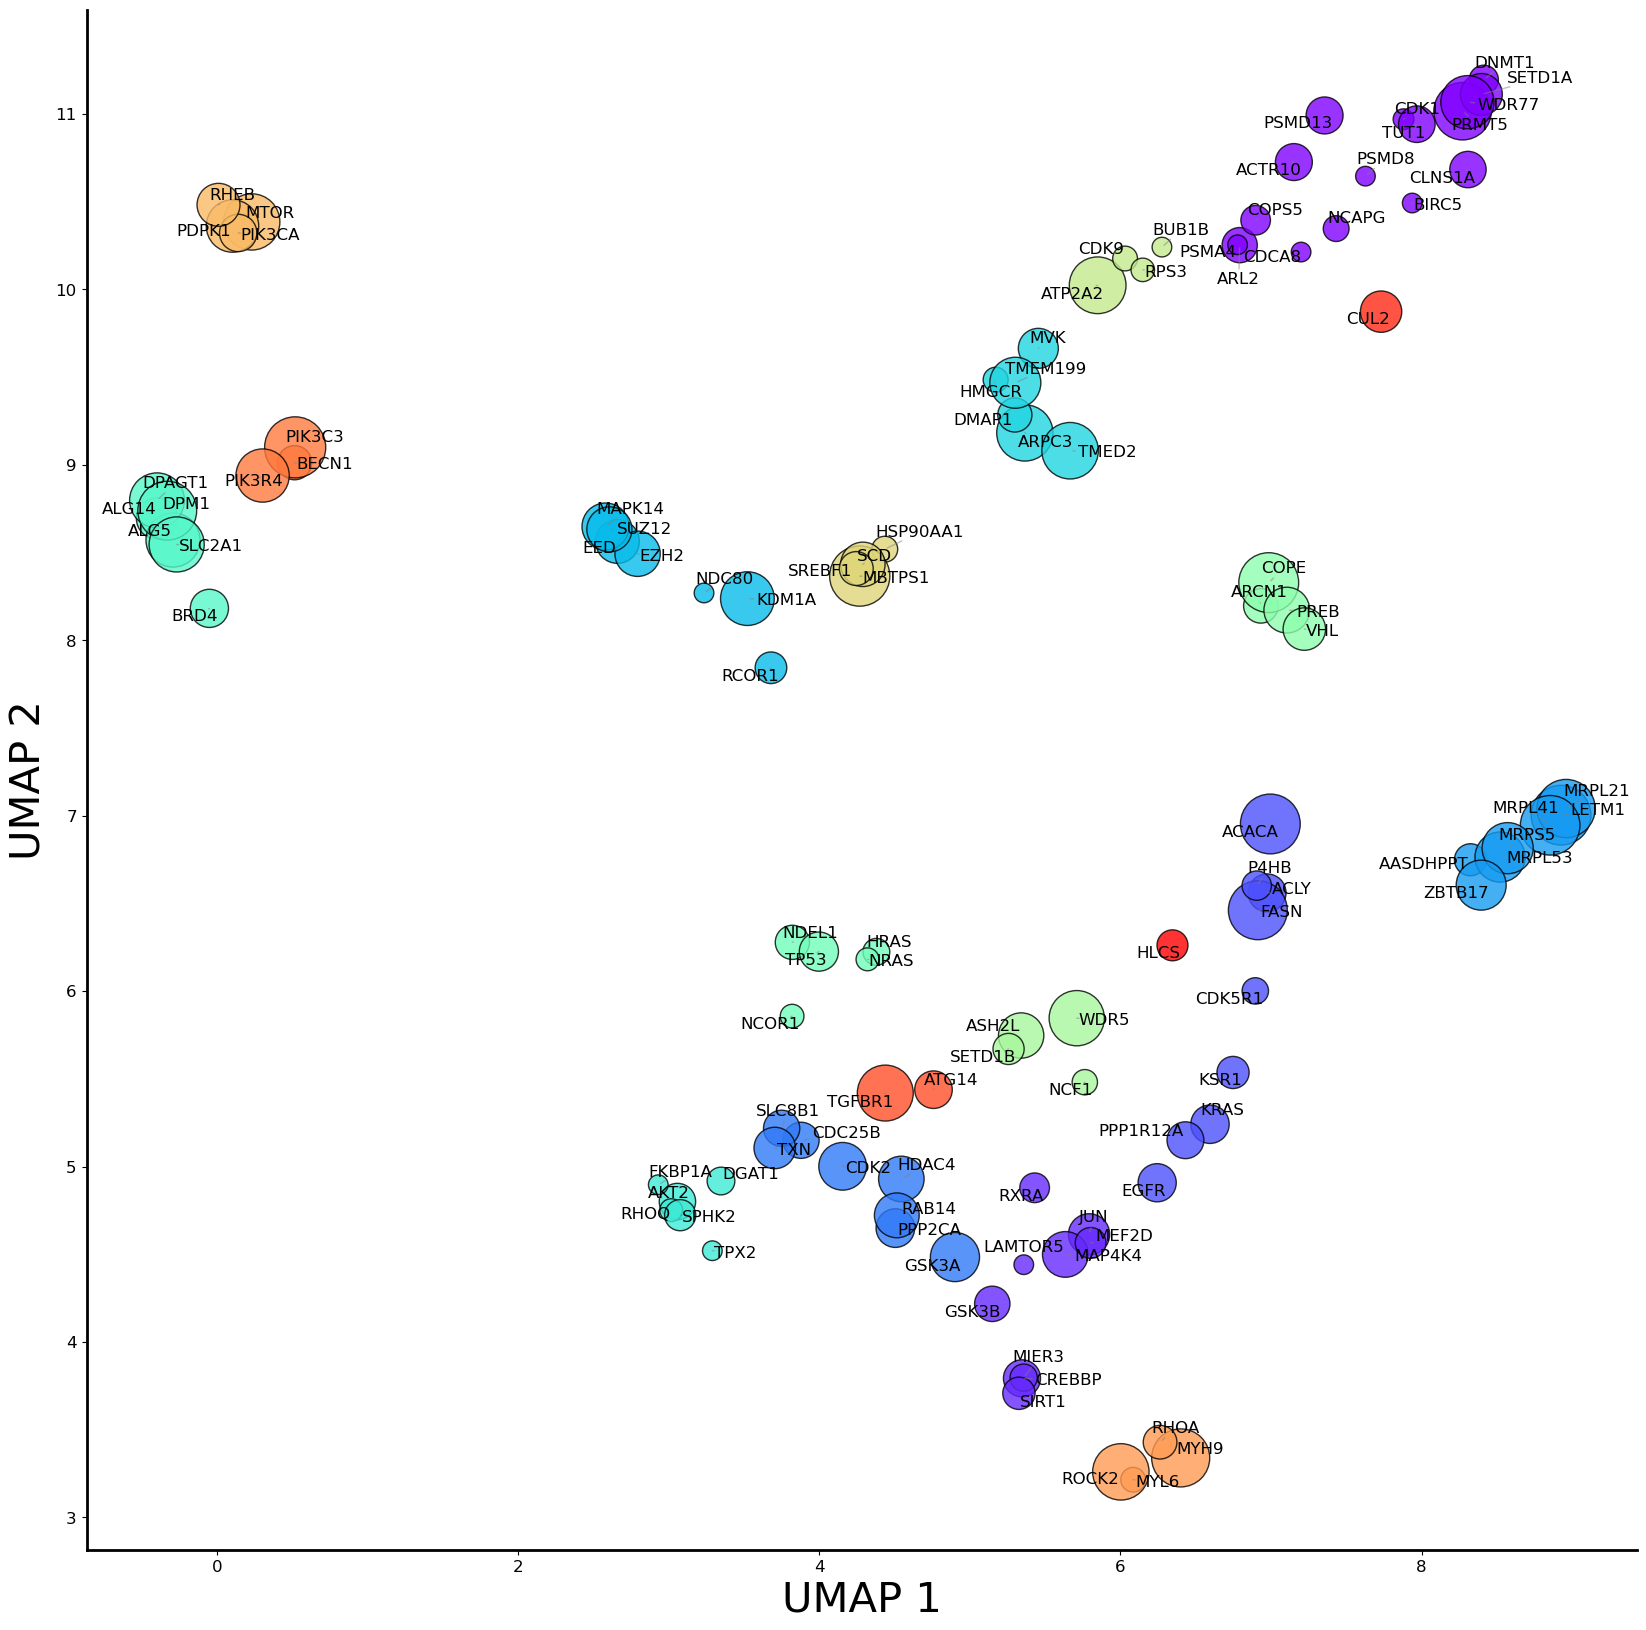

UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=5, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [89]:
select_genes = list(auc_metrics[auc_metrics.max(axis=1) > 0.55].index.values)

plotting.compute_plot_umap(gene_embeddings = cpdino_300_gene_embeddings, 
                            selected_genes=select_genes,
                            within_gene_gRNA_similarity_scores = gRNAscores_simple, 
                            neighbors = 5, 
                            leiden_resolution = 1, 
                            max_community_size = 50,
                            adjust_texts = True,
                            clusters = None,
                            dot_size_min = 200,
                            dot_size_max = 2000,
                            font_size = 12,
                            random_state = 42
                            )